In [94]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from collections import OrderedDict

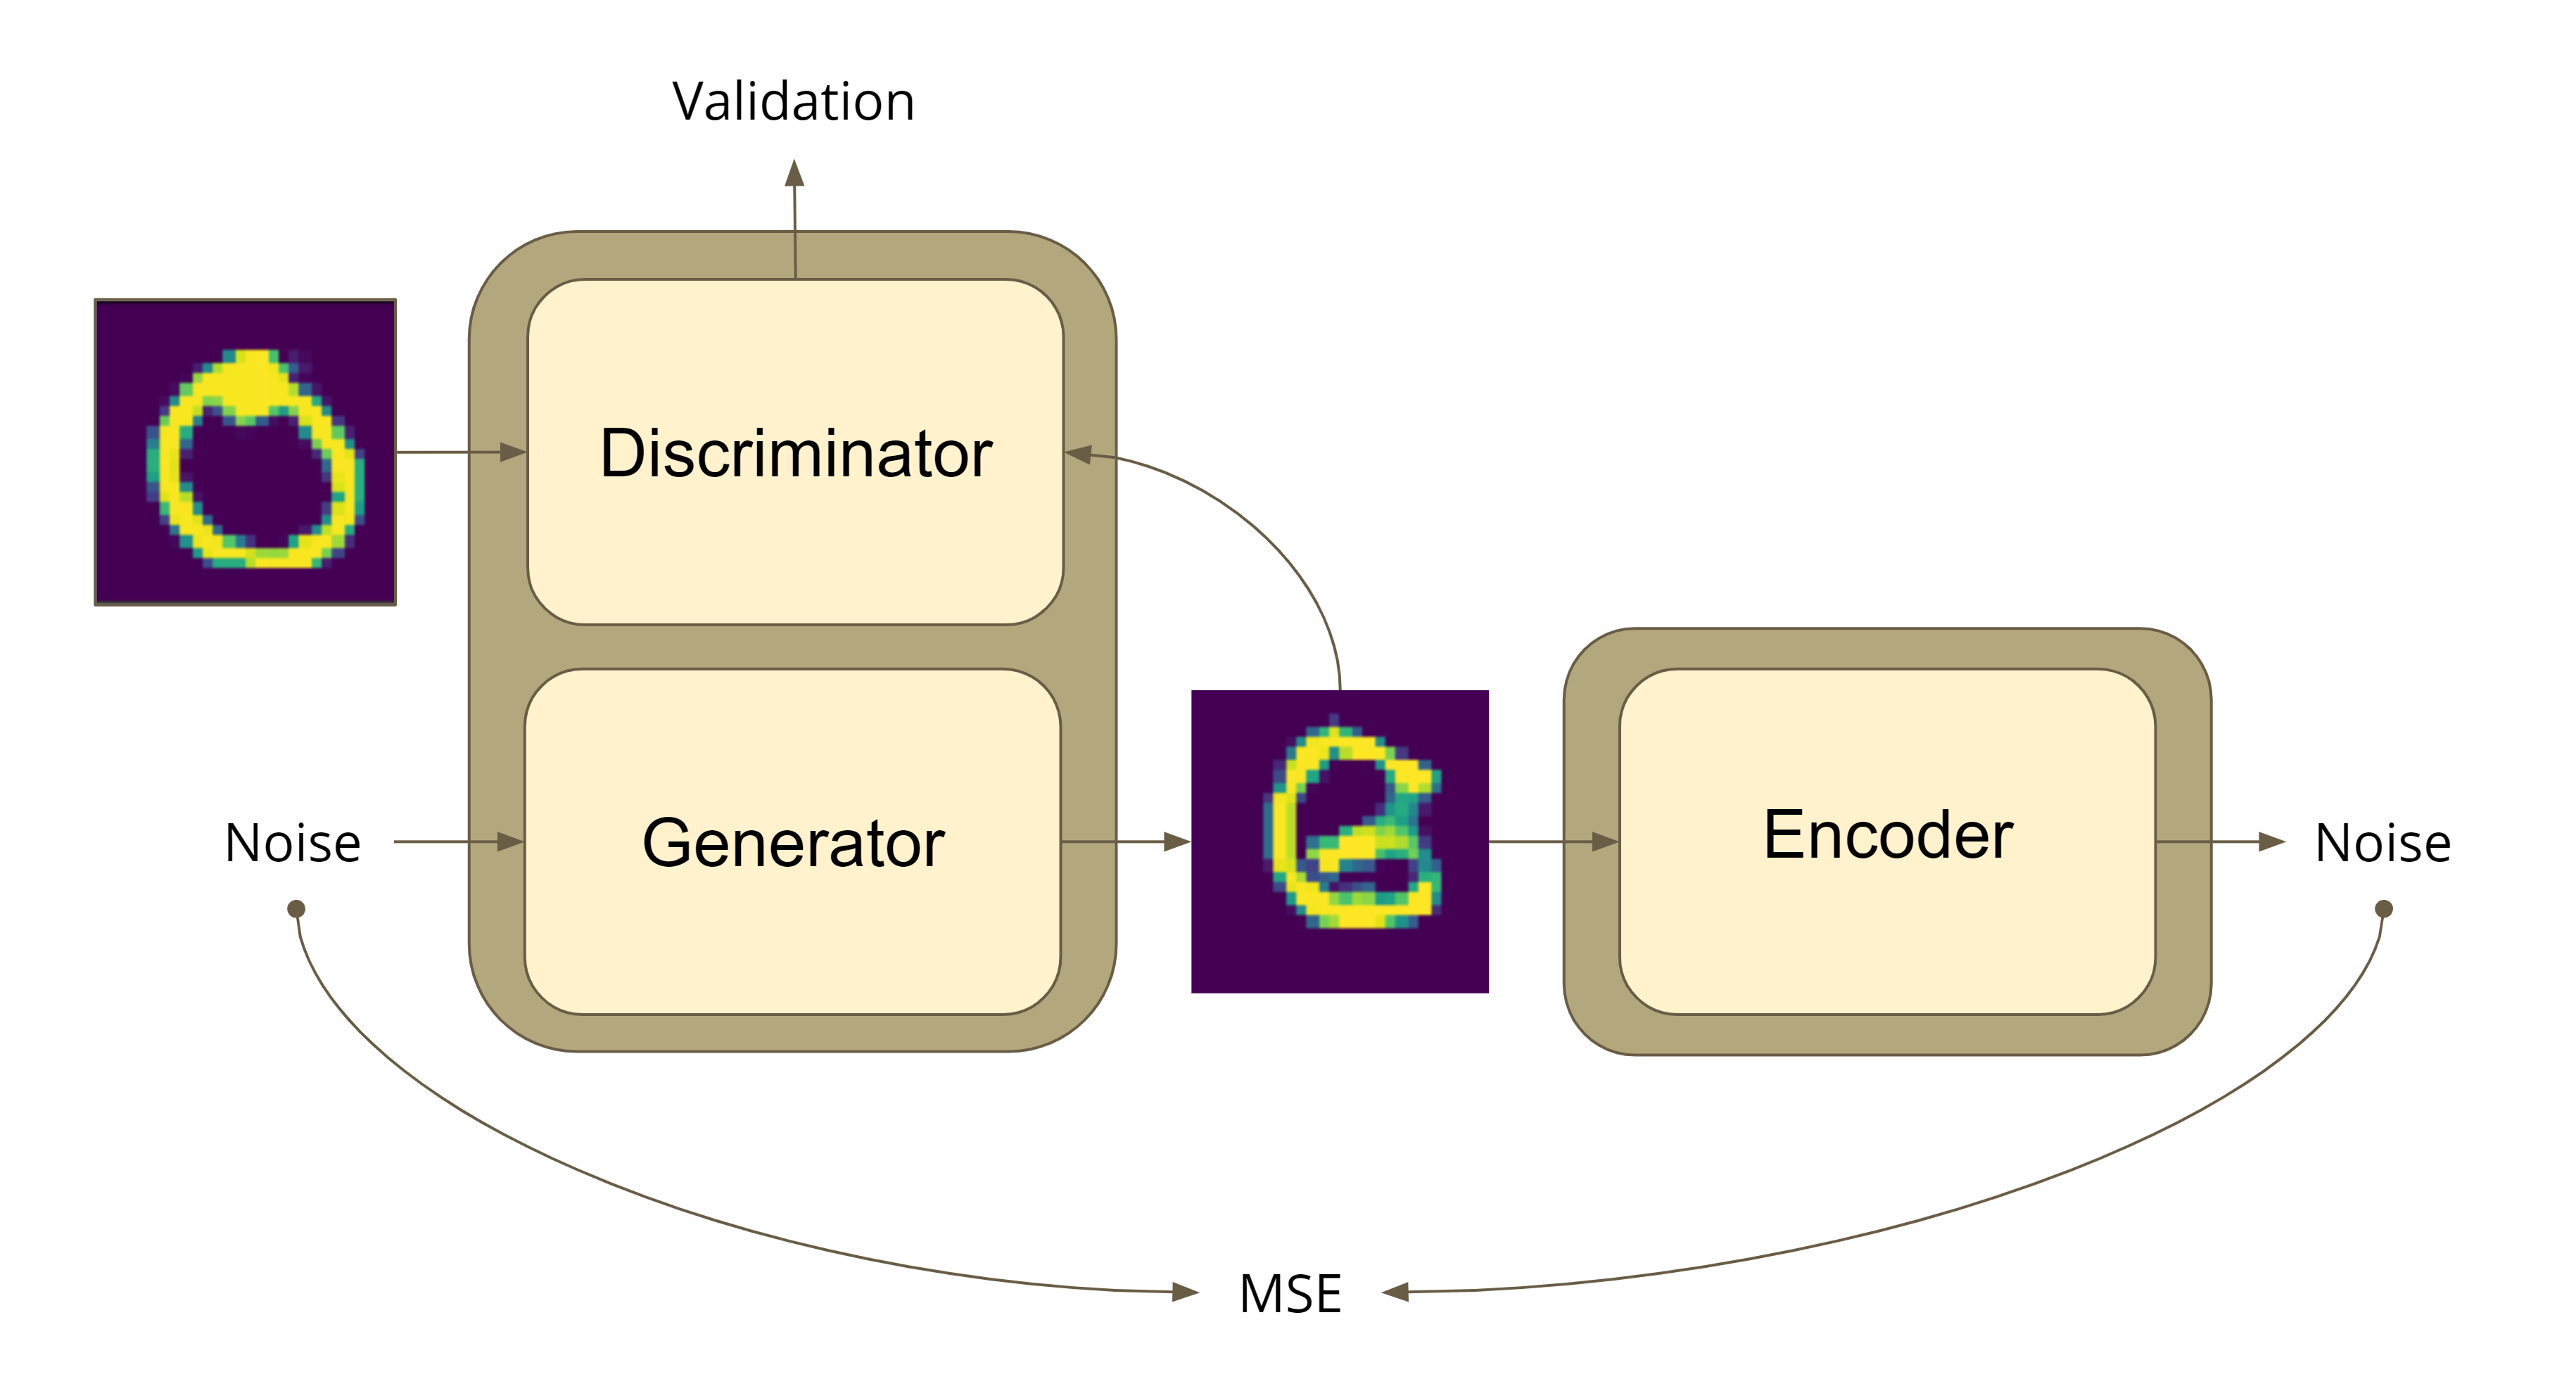

In [2]:
class ImageConv(nn.Sequential):
    def __init__(self):
        super().__init__(                                   # B 1   28  28
            nn.BatchNorm2d(num_features=1),
            nn.Conv2d(1, 64, 3, stride=1, padding=3),       # B 64  32  32  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),      # B 64  32  32
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 64  16  16
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),     # B 128 16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),    # B 128 16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 128 8   8
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),    # B 256 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),    # B 256 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 256 4   4
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),    # B 512 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),    # B 512 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 512 2   2
            nn.Dropout2d(0.2, inplace=True)
        )

In [102]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(                                                # B 100
            nn.Linear(100, 1024),                                               # B 1024
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.decoder = nn.Sequential(                                           # B 100 1   1
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 512, 4, stride=1, padding=0, bias=False),  # B 512 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),                        # B 512 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),   # B 256 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),                        # B 256 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),   # B 128 16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),                        # B 128 16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),    # B 64  32  32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),                          # B 64  32  32
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),                          # B 64  30  30
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),                          # B 64  28  28
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),                           # B 1   28  28
            nn.ReLU(inplace=True)            
        )
    
    def forward(self, z):
        # z     B   100

        z = self.fc(z)                                                          # B 1024
        z = z.view(-1, 1024, 1, 1)                                              # B 1024    1   1
        out = self.decoder(z)                                                   # B 1       28  28
        out = out.squeeze(1)                                                    # B 28      28
        
        return out.clamp(0, 1)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = ImageConv()

        self.fc = nn.Sequential(
            nn.Linear(2048, 512),              # B 512
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(512, 256),               # B 256
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(256, 1),                 # B 1
            nn.Sigmoid()
        )
    
    def forward(self, images):
        # images                                  B   28  28
        
        images = images.unsqueeze(1)            # B 1   28  28
        out = self.conv(images)                 # B 512 2   2
        out = out.flatten(1)                    # B 2048
        out = self.fc(out)                      # B 1
        out = out.squeeze()                     # B
        return out

In [77]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = ImageConv()

        self.fc = nn.Sequential(
            nn.Linear(2048, 512),              # B 512
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(512, 256),               # B 256
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(256, 128),               # B 128
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(128, 100),               # B 100
            nn.ReLU(inplace=True)
        )
    
    def forward(self, images):
        # images                                # B 28  28
        
        images = images.unsqueeze(1)            # B 1   28  28
        out = self.conv(images)                 # B 512 2   2
        out = out.flatten(1)                    # B 2048
        out = self.fc(out)                      # B 100
        return out

In [6]:
def get_batches(X, y=None, batch_size=128, shuffle=True):
    if y is not None:
        assert X.shape[0] == y.shape[0]

    num_batches = int(np.ceil(X.shape[0] * 1.0 / batch_size))

    if shuffle:
        indices = np.random.permutation(X.shape[0])
        X = X[indices]
        if y is not None:
            y = y[indices]

    for batch in range(num_batches):
        start = batch * batch_size
        end = min((batch + 1) * batch_size, X.shape[0])
        yield (batch, X[start:end], y[start:end]) if y is not None else (batch, X[start:end])

In [27]:
def generator_train_step(generator, discriminator, batch_size, g_optimizer):
    g_optimizer.zero_grad()

    z = torch.randn(batch_size, 100, device='cuda')

    fake_images = generator(z)                  # B 28  28
    validity = discriminator(fake_images)       # B

    g_loss = F.binary_cross_entropy(validity, torch.ones(batch_size, device='cuda'))
    g_loss.backward()
    g_optimizer.step()
    return float(g_loss)

In [25]:
def discriminator_train_step(discriminator, fake_images, real_images, d_optimizer):
    # fake_images           B   28  28
    # real_images           B   28  28
    d_optimizer.zero_grad()

    real_images = torch.tensor(real_images, device='cuda')
    images = torch.cat((fake_images, real_images), dim=0)       # 2B    28  28
    expected = torch.cat((                                      # 2B
        torch.zeros(fake_images.shape[0], device='cuda'),
        torch.ones(real_images.shape[0], device='cuda')
    ), dim=0)

    validity = discriminator(images)                            # 2B
    d_loss = F.binary_cross_entropy(validity, expected)

    d_loss.backward()
    d_optimizer.step()
    return float(d_loss)

In [9]:
def encoder_train_step(encoder, fake_images, noise, e_optimizer):
    # fake_images           B   28  28
    # noise                 B   100
    e_optimizer.zero_grad()

    encoded = encoder(fake_images)      # B 100

    e_loss = F.mse_loss(encoded, noise)

    e_loss.backward()
    e_optimizer.step()
    return float(e_loss)

In [49]:
def train_cycleGAN(generator, discriminator, encoder, images, g_optimizer, d_optimizer, e_optimizer, batch_size, discriminator_step):
    g_loss, g_count = 0, 0
    d_loss, d_count = 0, 0
    e_loss, e_count = 0, 0

    generator.train()
    discriminator.train()
    encoder.train()

    batches = get_batches(images, batch_size=batch_size)

    iter = 0
    while True:
        if iter % 2 == 0:   # Generator train
            g_loss += generator_train_step(generator, discriminator, batch_size, g_optimizer)
            g_count += 1
        else:               # Encoder and maybe discriminator train
            noise = torch.randn(batch_size, 100, device='cuda')     # B 100
            with torch.no_grad():
                fake_images = generator(noise).detach()             # B 28  28
            e_loss += encoder_train_step(encoder, fake_images, noise, e_optimizer)
            e_count += 1

            if (iter // 2) % discriminator_step == 0:   # Discriminator train
                try:
                    _, real_images = next(batches)
                except StopIteration:
                    break
                
                d_loss += discriminator_train_step(discriminator, fake_images, real_images, d_optimizer)
                d_count += 1
        iter += 1

        if iter % 40 == 0:
            print(f'Iteration {iter:4d} - g_loss: {g_loss * 1.0 / g_count:.2e} - d_loss: {d_loss * 1.0 / d_count:.2e} - e_loss: {e_loss * 1.0 / e_count:.2e}')
    
    g_loss /= g_count * 1.0
    d_loss /= d_count * 1.0
    e_loss /= e_count * 1.0

    return g_loss, d_loss, e_loss


In [11]:
def evaluate_encoder(generator, encoder, batch_size, number_of_batches):
    loss = 0
    for iter in range(number_of_batches):
        noise = torch.randn(batch_size, 100, device='cuda')     # B 100
        images = generator(noise)                               # B 28  28
        reconstructed_noise = encoder(images)                   # B 100
        loss += float(F.mse_loss(reconstructed_noise, noise))
    
    loss /= number_of_batches * 1.0
    return loss

In [12]:
def draw(images, texts, columns=1, rows=1):
    fig = plt.figure(figsize=(2 * columns, 2 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i].reshape((28, 28)))

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

In [34]:
def display_GAN(generator, encoder, images, columns, rows):
    batches = get_batches(images, batch_size=columns * rows)
    _, real_images = next(batches)          # row*col   28  28
    batches.close()

    real_images = torch.tensor(real_images, device='cuda')
    noise = encoder(real_images)            # row*col   100
    generated_images = generator(noise)     # row*col   28  28

    images_to_show = np.zeros((rows * columns, 2, 28, 28))
    images_to_show[:,0] = real_images.cpu().numpy()
    images_to_show[:,1] = generated_images.cpu().numpy()
    images_to_show = images_to_show.reshape(rows * columns * 2, 28, 28)

    texts = np.zeros((rows * columns, 2), dtype=object)
    texts[:,0] = np.array(['real' for _ in range(rows * columns)])
    texts[:,1] = np.array(['generated' for _ in range(rows * columns)])
    texts = texts.reshape(rows * columns * 2)

    draw(images_to_show, texts, columns * 2, rows)

In [14]:
def evaluate_cycleGAN(generator, encoder, images, columns, rows, batch_size, number_of_batches):
    with torch.no_grad():
        generator.eval()
        encoder.eval()

        display_GAN(generator, encoder, images, columns, rows)
        return evaluate_encoder(generator, encoder, batch_size, number_of_batches)

In [15]:
mnist = fetch_openml(name='mnist_784')

In [16]:
images = mnist.data.reshape((-1, 28, 28)).astype('float32')
images.shape

(70000, 28, 28)

In [54]:
trainset, testset = train_test_split(images, test_size=0.2)
trainset, validationset = train_test_split(trainset, test_size=0.1)
trainset.shape, testset.shape, validationset.shape

((50400, 28, 28), (14000, 28, 28), (5600, 28, 28))

In [108]:
generator = Generator().cuda()
generator.decoder.load_state_dict(OrderedDict([(k[3:], v) for k, v in torch.load('drive/My Drive/gan-generator-model-e09.pt').items() if k.startswith('dc.')]))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-5)

In [109]:
discriminator = Discriminator().cuda()
discriminator.load_state_dict(torch.load('drive/My Drive/gan-discriminator-model-e09.pt'))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-5)

In [110]:
encoder = Encoder().cuda()
encoder.conv.load_state_dict(torch.load('drive/My Drive/mnist-autoencoder-conv-model.pt'))
e_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)

Iteration   40 - g_loss: 6.59e-01 - d_loss: 7.40e-01 - e_loss: 1.00e+00
Iteration   80 - g_loss: 6.22e-01 - d_loss: 7.15e-01 - e_loss: 1.00e+00
Iteration  120 - g_loss: 5.93e-01 - d_loss: 6.91e-01 - e_loss: 1.00e+00
Iteration  160 - g_loss: 5.64e-01 - d_loss: 6.70e-01 - e_loss: 1.00e+00
Iteration  200 - g_loss: 5.34e-01 - d_loss: 6.50e-01 - e_loss: 1.00e+00
Iteration  240 - g_loss: 5.03e-01 - d_loss: 6.31e-01 - e_loss: 1.00e+00
Iteration  280 - g_loss: 4.72e-01 - d_loss: 6.11e-01 - e_loss: 1.00e+00
Iteration  320 - g_loss: 4.42e-01 - d_loss: 5.91e-01 - e_loss: 1.00e+00
Iteration  360 - g_loss: 4.13e-01 - d_loss: 5.72e-01 - e_loss: 1.00e+00
Iteration  400 - g_loss: 3.87e-01 - d_loss: 5.52e-01 - e_loss: 1.00e+00
Iteration  440 - g_loss: 3.62e-01 - d_loss: 5.31e-01 - e_loss: 1.00e+00
Iteration  480 - g_loss: 3.40e-01 - d_loss: 5.10e-01 - e_loss: 9.99e-01
Iteration  520 - g_loss: 3.19e-01 - d_loss: 4.89e-01 - e_loss: 9.99e-01
Iteration  560 - g_loss: 3.00e-01 - d_loss: 4.67e-01 - e_loss: 9

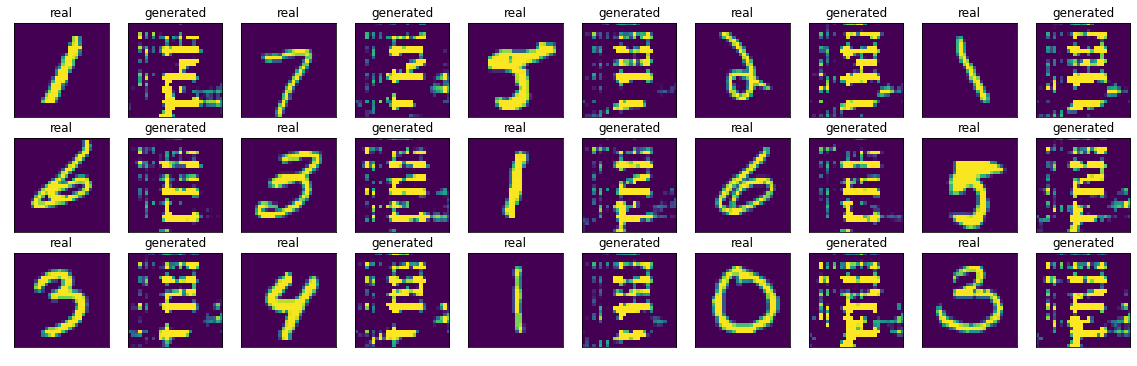

Validation loss: 9.69e-01
Iteration   40 - g_loss: 1.94e-03 - d_loss: 2.33e-03 - e_loss: 9.79e-01
Iteration   80 - g_loss: 1.93e-03 - d_loss: 2.40e-03 - e_loss: 9.79e-01
Iteration  120 - g_loss: 1.88e-03 - d_loss: 2.50e-03 - e_loss: 9.78e-01
Iteration  160 - g_loss: 1.84e-03 - d_loss: 2.41e-03 - e_loss: 9.77e-01
Iteration  200 - g_loss: 1.79e-03 - d_loss: 2.31e-03 - e_loss: 9.78e-01
Iteration  240 - g_loss: 1.74e-03 - d_loss: 2.23e-03 - e_loss: 9.78e-01
Iteration  280 - g_loss: 1.71e-03 - d_loss: 2.16e-03 - e_loss: 9.78e-01
Iteration  320 - g_loss: 1.67e-03 - d_loss: 2.08e-03 - e_loss: 9.77e-01
Iteration  360 - g_loss: 1.63e-03 - d_loss: 2.03e-03 - e_loss: 9.77e-01
Iteration  400 - g_loss: 1.59e-03 - d_loss: 1.97e-03 - e_loss: 9.77e-01
Iteration  440 - g_loss: 1.56e-03 - d_loss: 1.93e-03 - e_loss: 9.77e-01
Iteration  480 - g_loss: 1.52e-03 - d_loss: 1.87e-03 - e_loss: 9.77e-01
Iteration  520 - g_loss: 1.50e-03 - d_loss: 1.82e-03 - e_loss: 9.76e-01
Iteration  560 - g_loss: 1.46e-03 - d_

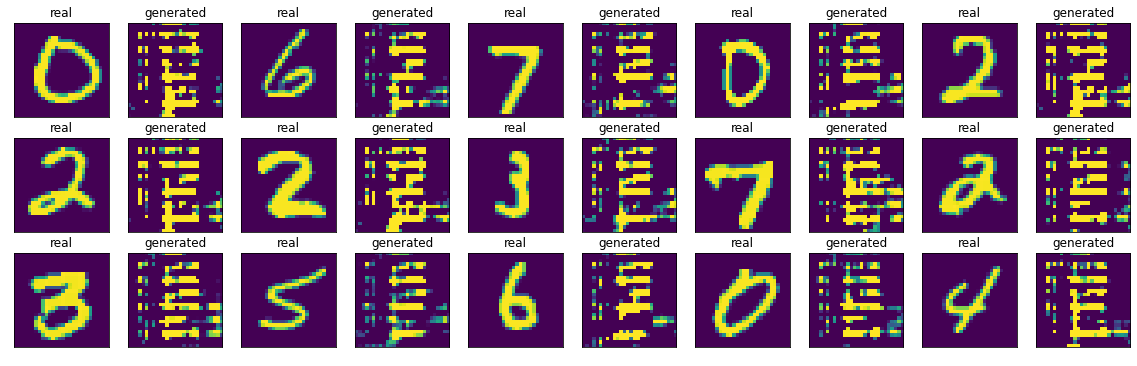

Validation loss: 9.54e-01
Iteration   40 - g_loss: 4.75e-04 - d_loss: 4.11e-04 - e_loss: 9.71e-01
Iteration   80 - g_loss: 4.75e-04 - d_loss: 4.48e-04 - e_loss: 9.68e-01
Iteration  120 - g_loss: 4.65e-04 - d_loss: 4.62e-04 - e_loss: 9.68e-01
Iteration  160 - g_loss: 4.64e-04 - d_loss: 4.90e-04 - e_loss: 9.68e-01
Iteration  200 - g_loss: 4.58e-04 - d_loss: 4.77e-04 - e_loss: 9.68e-01
Iteration  240 - g_loss: 4.55e-04 - d_loss: 4.73e-04 - e_loss: 9.68e-01
Iteration  280 - g_loss: 4.51e-04 - d_loss: 4.76e-04 - e_loss: 9.68e-01
Iteration  320 - g_loss: 4.46e-04 - d_loss: 4.83e-04 - e_loss: 9.67e-01
Iteration  360 - g_loss: 4.39e-04 - d_loss: 4.70e-04 - e_loss: 9.67e-01
Iteration  400 - g_loss: 4.30e-04 - d_loss: 4.67e-04 - e_loss: 9.67e-01
Iteration  440 - g_loss: 4.25e-04 - d_loss: 4.54e-04 - e_loss: 9.67e-01
Iteration  480 - g_loss: 4.23e-04 - d_loss: 4.44e-04 - e_loss: 9.67e-01


In [ ]:
batch_size = 256
epochs = 50
discriminator_step = 4

g_loss, d_loss, e_loss = ([] for _ in range(3))

for e in range(epochs):
    start_time = time()

    e_g_loss, e_d_loss, e_e_loss = train_cycleGAN(
        generator, discriminator, encoder,
        trainset,
        g_optimizer, d_optimizer, e_optimizer,
        batch_size, discriminator_step)
    
    end_time = time()

    torch.save(discriminator.state_dict(), f'drive/My Drive/cycle-gan-discriminator-model-e{e:02d}.pt')
    torch.save(generator.state_dict(), f'drive/My Drive/cycle-gan-generator-model-e{e:02d}.pt')
    torch.save(encoder.state_dict(), f'drive/My Drive/cycle-gan-encoder-model-e{e:02d}.pt')

    print(f'Epoch {e+1:2} finished in {end_time - start_time:.2f}s - g_loss: {e_g_loss:.2e} - d_loss: {e_d_loss:.2e} - e_loss: {e_e_loss:.2e}')

    g_loss.append(e_g_loss)
    d_loss.append(e_d_loss)
    e_loss.append(e_e_loss)

    eval_loss = evaluate_cycleGAN(generator, encoder, validationset, 5, 3, 256, 10)
    print(f'Validation loss: {eval_loss:.2e}')

Iteration   40 - g_loss: 8.67e-06 - d_loss: 2.28e-06 - e_loss: 9.57e-01
Iteration   80 - g_loss: 8.48e-06 - d_loss: 2.43e-06 - e_loss: 9.57e-01
Iteration  120 - g_loss: 8.86e-06 - d_loss: 2.37e-06 - e_loss: 9.57e-01
Iteration  160 - g_loss: 9.02e-06 - d_loss: 2.52e-06 - e_loss: 9.58e-01
Iteration  200 - g_loss: 8.88e-06 - d_loss: 2.49e-06 - e_loss: 9.58e-01
Iteration  240 - g_loss: 9.00e-06 - d_loss: 2.54e-06 - e_loss: 9.58e-01
Iteration  280 - g_loss: 9.16e-06 - d_loss: 2.41e-06 - e_loss: 9.58e-01
Iteration  320 - g_loss: 9.02e-06 - d_loss: 2.39e-06 - e_loss: 9.58e-01
Iteration  360 - g_loss: 9.11e-06 - d_loss: 2.53e-06 - e_loss: 9.58e-01
Epoch 21 finished in 148.07s - g_loss: 8.94e-06 - d_loss: 2.52e-06 - e_loss: 9.58e-01


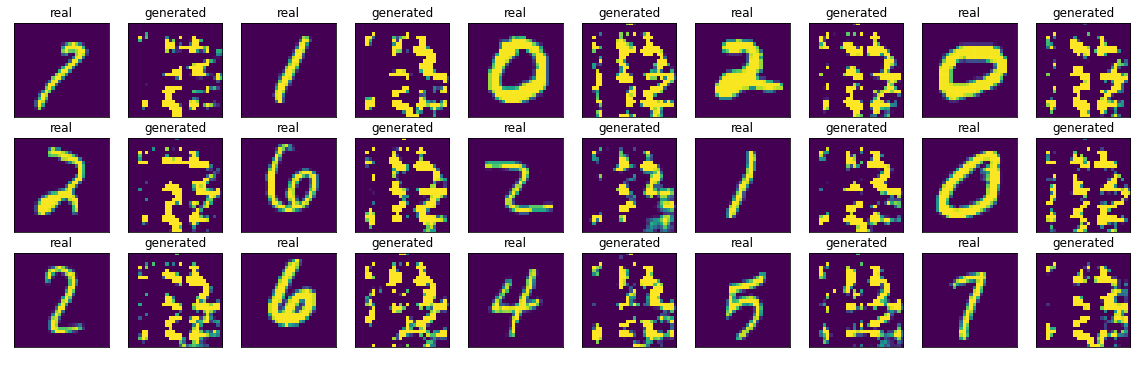

Validation loss: 9.49e-01
Iteration   40 - g_loss: 8.79e-06 - d_loss: 1.85e-06 - e_loss: 9.59e-01
Iteration   80 - g_loss: 8.02e-06 - d_loss: 2.78e-06 - e_loss: 9.56e-01
Iteration  120 - g_loss: 8.93e-06 - d_loss: 2.48e-06 - e_loss: 9.57e-01
Iteration  160 - g_loss: 8.72e-06 - d_loss: 2.59e-06 - e_loss: 9.57e-01
Iteration  200 - g_loss: 8.78e-06 - d_loss: 2.50e-06 - e_loss: 9.57e-01
Iteration  240 - g_loss: 8.73e-06 - d_loss: 2.40e-06 - e_loss: 9.57e-01
Iteration  280 - g_loss: 8.82e-06 - d_loss: 2.33e-06 - e_loss: 9.57e-01
Iteration  320 - g_loss: 8.59e-06 - d_loss: 2.52e-06 - e_loss: 9.57e-01
Iteration  360 - g_loss: 8.49e-06 - d_loss: 2.49e-06 - e_loss: 9.57e-01
Epoch 22 finished in 148.11s - g_loss: 8.41e-06 - d_loss: 2.39e-06 - e_loss: 9.58e-01


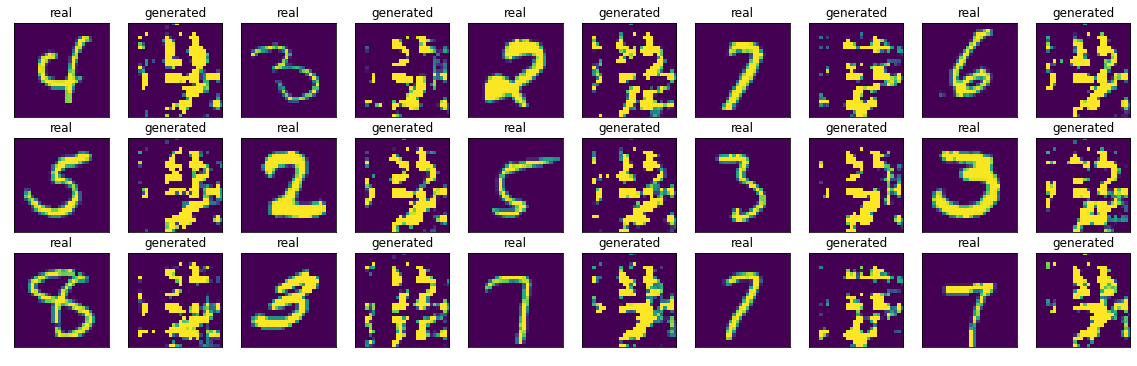

Validation loss: 9.42e-01
Iteration   40 - g_loss: 7.79e-06 - d_loss: 1.78e-06 - e_loss: 9.59e-01
Iteration   80 - g_loss: 7.36e-06 - d_loss: 1.94e-06 - e_loss: 9.59e-01
Iteration  120 - g_loss: 7.40e-06 - d_loss: 1.83e-06 - e_loss: 9.58e-01
Iteration  160 - g_loss: 7.61e-06 - d_loss: 1.80e-06 - e_loss: 9.57e-01
Iteration  200 - g_loss: 7.55e-06 - d_loss: 1.87e-06 - e_loss: 9.57e-01
Iteration  240 - g_loss: 7.51e-06 - d_loss: 1.92e-06 - e_loss: 9.57e-01
Iteration  280 - g_loss: 7.45e-06 - d_loss: 1.89e-06 - e_loss: 9.56e-01
Iteration  320 - g_loss: 7.48e-06 - d_loss: 1.87e-06 - e_loss: 9.56e-01
Iteration  360 - g_loss: 7.34e-06 - d_loss: 2.23e-06 - e_loss: 9.56e-01
Epoch 23 finished in 148.22s - g_loss: 7.15e-06 - d_loss: 2.17e-06 - e_loss: 9.56e-01


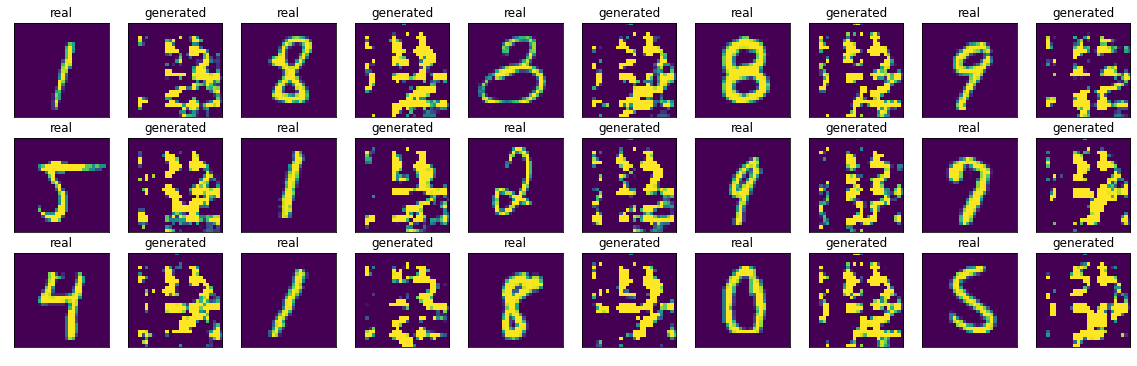

Validation loss: 9.40e-01
Iteration   40 - g_loss: 5.92e-06 - d_loss: 2.71e-06 - e_loss: 9.57e-01
Iteration   80 - g_loss: 6.37e-06 - d_loss: 1.97e-06 - e_loss: 9.58e-01
Iteration  120 - g_loss: 6.62e-06 - d_loss: 1.73e-06 - e_loss: 9.58e-01
Iteration  160 - g_loss: 6.47e-06 - d_loss: 1.59e-06 - e_loss: 9.57e-01
Iteration  200 - g_loss: 6.44e-06 - d_loss: 1.68e-06 - e_loss: 9.57e-01
Iteration  240 - g_loss: 6.41e-06 - d_loss: 1.79e-06 - e_loss: 9.57e-01
Iteration  280 - g_loss: 6.30e-06 - d_loss: 1.85e-06 - e_loss: 9.57e-01
Iteration  320 - g_loss: 6.29e-06 - d_loss: 1.84e-06 - e_loss: 9.57e-01
Iteration  360 - g_loss: 6.23e-06 - d_loss: 1.79e-06 - e_loss: 9.57e-01
Epoch 24 finished in 148.22s - g_loss: 6.14e-06 - d_loss: 1.84e-06 - e_loss: 9.56e-01


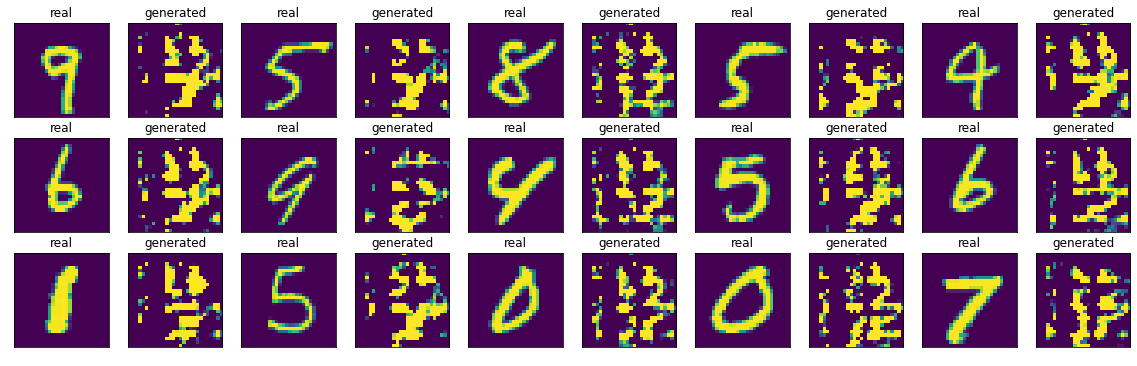

Validation loss: 9.37e-01
Iteration   40 - g_loss: 5.52e-06 - d_loss: 2.92e-06 - e_loss: 9.57e-01
Iteration   80 - g_loss: 5.96e-06 - d_loss: 2.10e-06 - e_loss: 9.57e-01
Iteration  120 - g_loss: 5.91e-06 - d_loss: 1.84e-06 - e_loss: 9.56e-01
Iteration  160 - g_loss: 5.80e-06 - d_loss: 1.74e-06 - e_loss: 9.56e-01
Iteration  200 - g_loss: 5.76e-06 - d_loss: 1.72e-06 - e_loss: 9.55e-01
Iteration  240 - g_loss: 5.71e-06 - d_loss: 1.66e-06 - e_loss: 9.55e-01
Iteration  280 - g_loss: 5.60e-06 - d_loss: 1.60e-06 - e_loss: 9.55e-01
Iteration  320 - g_loss: 5.54e-06 - d_loss: 1.52e-06 - e_loss: 9.55e-01
Iteration  360 - g_loss: 5.53e-06 - d_loss: 1.46e-06 - e_loss: 9.55e-01
Epoch 25 finished in 148.13s - g_loss: 5.56e-06 - d_loss: 1.49e-06 - e_loss: 9.55e-01


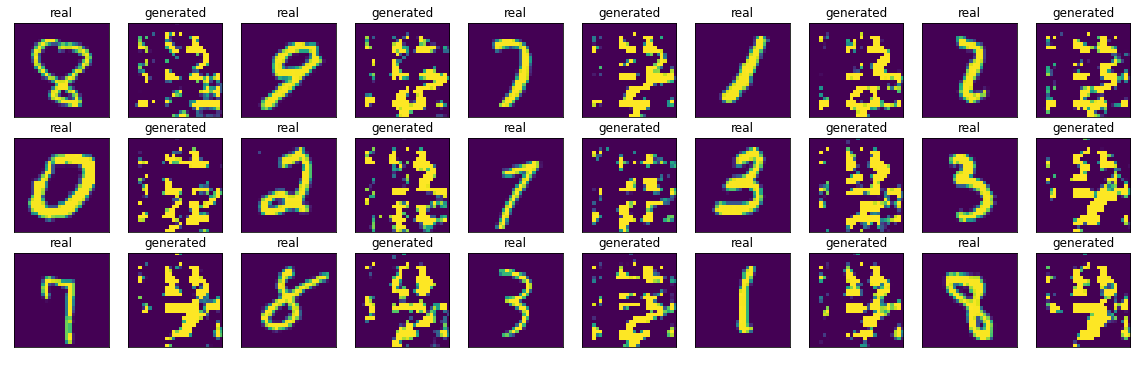

Validation loss: 9.41e-01
Iteration   40 - g_loss: 5.85e-06 - d_loss: 3.10e-06 - e_loss: 9.57e-01
Iteration   80 - g_loss: 5.43e-06 - d_loss: 2.17e-06 - e_loss: 9.57e-01
Iteration  120 - g_loss: 5.34e-06 - d_loss: 1.87e-06 - e_loss: 9.55e-01
Iteration  160 - g_loss: 5.39e-06 - d_loss: 1.66e-06 - e_loss: 9.55e-01
Iteration  200 - g_loss: 5.19e-06 - d_loss: 1.57e-06 - e_loss: 9.56e-01
Iteration  240 - g_loss: 5.09e-06 - d_loss: 1.51e-06 - e_loss: 9.56e-01
Iteration  280 - g_loss: 5.08e-06 - d_loss: 1.48e-06 - e_loss: 9.56e-01
Iteration  320 - g_loss: 4.99e-06 - d_loss: 1.42e-06 - e_loss: 9.56e-01
Iteration  360 - g_loss: 4.98e-06 - d_loss: 1.44e-06 - e_loss: 9.56e-01
Epoch 26 finished in 147.98s - g_loss: 4.90e-06 - d_loss: 1.38e-06 - e_loss: 9.56e-01


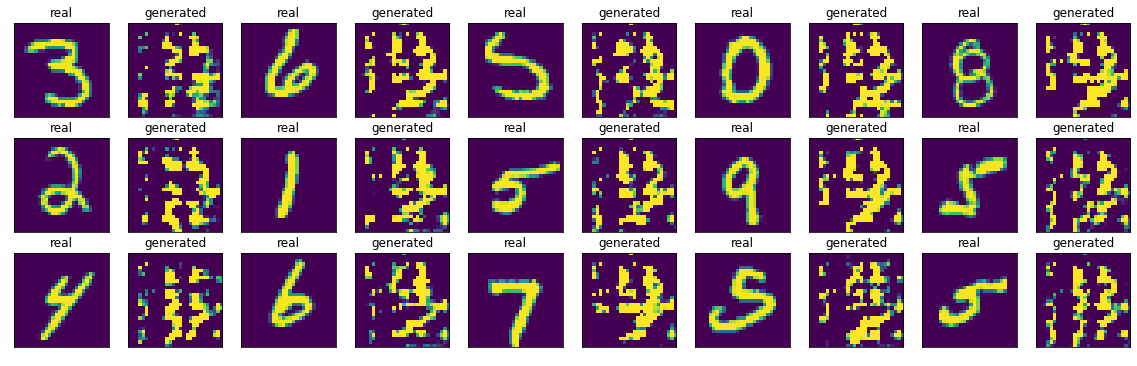

Validation loss: 9.38e-01
Iteration   40 - g_loss: 3.84e-06 - d_loss: 8.47e-07 - e_loss: 9.56e-01
Iteration   80 - g_loss: 3.97e-06 - d_loss: 9.15e-07 - e_loss: 9.57e-01
Iteration  120 - g_loss: 4.36e-06 - d_loss: 9.45e-07 - e_loss: 9.56e-01
Iteration  160 - g_loss: 4.14e-06 - d_loss: 9.45e-07 - e_loss: 9.56e-01
Iteration  200 - g_loss: 4.13e-06 - d_loss: 9.86e-07 - e_loss: 9.55e-01
Iteration  240 - g_loss: 4.08e-06 - d_loss: 1.05e-06 - e_loss: 9.55e-01
Iteration  280 - g_loss: 4.13e-06 - d_loss: 1.18e-06 - e_loss: 9.55e-01
Iteration  320 - g_loss: 4.14e-06 - d_loss: 1.15e-06 - e_loss: 9.55e-01
Iteration  360 - g_loss: 4.11e-06 - d_loss: 1.11e-06 - e_loss: 9.55e-01
Epoch 27 finished in 147.95s - g_loss: 4.17e-06 - d_loss: 1.09e-06 - e_loss: 9.55e-01


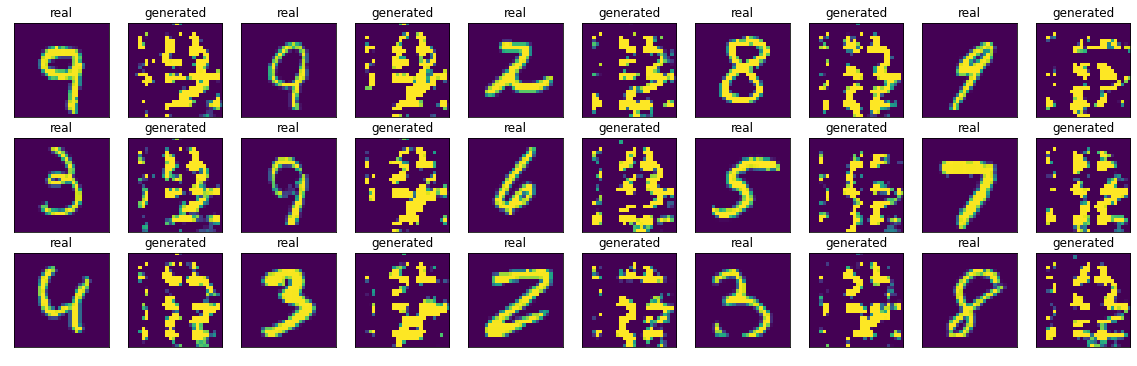

Validation loss: 9.37e-01
Iteration   40 - g_loss: 5.01e-06 - d_loss: 7.67e-07 - e_loss: 9.52e-01
Iteration   80 - g_loss: 4.63e-06 - d_loss: 8.14e-07 - e_loss: 9.52e-01
Iteration  120 - g_loss: 4.47e-06 - d_loss: 9.13e-07 - e_loss: 9.53e-01
Iteration  160 - g_loss: 4.40e-06 - d_loss: 9.96e-07 - e_loss: 9.53e-01
Iteration  200 - g_loss: 4.30e-06 - d_loss: 9.68e-07 - e_loss: 9.53e-01
Iteration  240 - g_loss: 4.23e-06 - d_loss: 1.04e-06 - e_loss: 9.53e-01
Iteration  280 - g_loss: 4.15e-06 - d_loss: 1.04e-06 - e_loss: 9.53e-01
Iteration  320 - g_loss: 4.02e-06 - d_loss: 1.04e-06 - e_loss: 9.53e-01
Iteration  360 - g_loss: 4.01e-06 - d_loss: 1.12e-06 - e_loss: 9.53e-01
Epoch 28 finished in 147.93s - g_loss: 3.94e-06 - d_loss: 1.10e-06 - e_loss: 9.53e-01


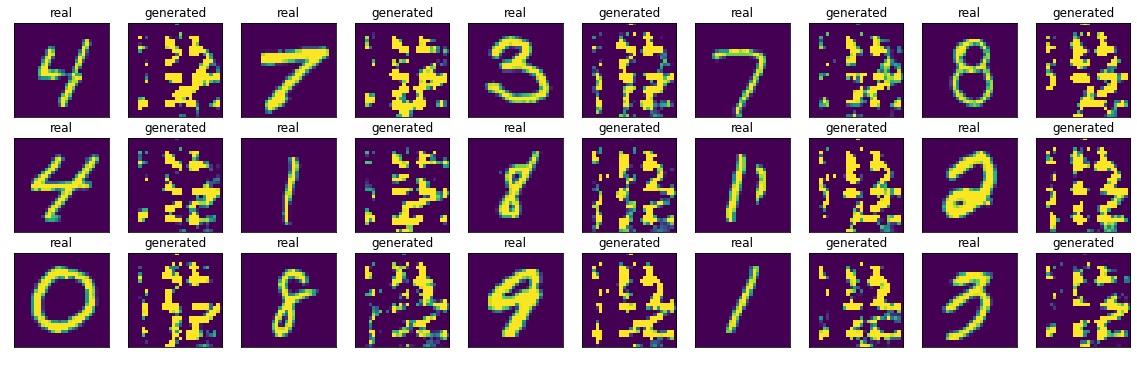

Validation loss: 9.39e-01
Iteration   40 - g_loss: 4.00e-06 - d_loss: 8.17e-07 - e_loss: 9.52e-01
Iteration   80 - g_loss: 3.79e-06 - d_loss: 8.11e-07 - e_loss: 9.53e-01
Iteration  120 - g_loss: 3.77e-06 - d_loss: 7.57e-07 - e_loss: 9.54e-01
Iteration  160 - g_loss: 3.98e-06 - d_loss: 9.08e-07 - e_loss: 9.53e-01
Iteration  200 - g_loss: 3.72e-06 - d_loss: 9.38e-07 - e_loss: 9.53e-01
Iteration  240 - g_loss: 3.76e-06 - d_loss: 9.05e-07 - e_loss: 9.53e-01
Iteration  280 - g_loss: 3.73e-06 - d_loss: 8.67e-07 - e_loss: 9.53e-01
Iteration  320 - g_loss: 3.68e-06 - d_loss: 8.48e-07 - e_loss: 9.54e-01
Iteration  360 - g_loss: 3.63e-06 - d_loss: 9.03e-07 - e_loss: 9.53e-01
Epoch 29 finished in 148.18s - g_loss: 3.56e-06 - d_loss: 8.73e-07 - e_loss: 9.54e-01


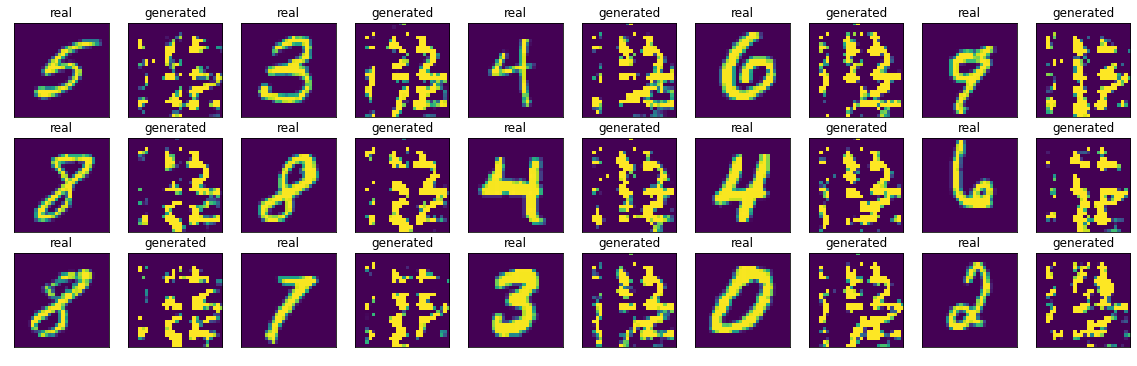

Validation loss: 9.36e-01
Iteration   40 - g_loss: 2.94e-06 - d_loss: 1.68e-06 - e_loss: 9.55e-01
Iteration   80 - g_loss: 3.03e-06 - d_loss: 1.17e-06 - e_loss: 9.52e-01
Iteration  120 - g_loss: 3.37e-06 - d_loss: 1.01e-06 - e_loss: 9.51e-01
Iteration  160 - g_loss: 3.28e-06 - d_loss: 9.44e-07 - e_loss: 9.52e-01
Iteration  200 - g_loss: 3.46e-06 - d_loss: 8.72e-07 - e_loss: 9.52e-01
Iteration  240 - g_loss: 3.34e-06 - d_loss: 8.83e-07 - e_loss: 9.53e-01
Iteration  280 - g_loss: 3.17e-06 - d_loss: 9.09e-07 - e_loss: 9.53e-01
Iteration  320 - g_loss: 3.13e-06 - d_loss: 9.50e-07 - e_loss: 9.53e-01
Iteration  360 - g_loss: 3.06e-06 - d_loss: 9.04e-07 - e_loss: 9.53e-01
Epoch 30 finished in 148.17s - g_loss: 3.07e-06 - d_loss: 8.65e-07 - e_loss: 9.53e-01


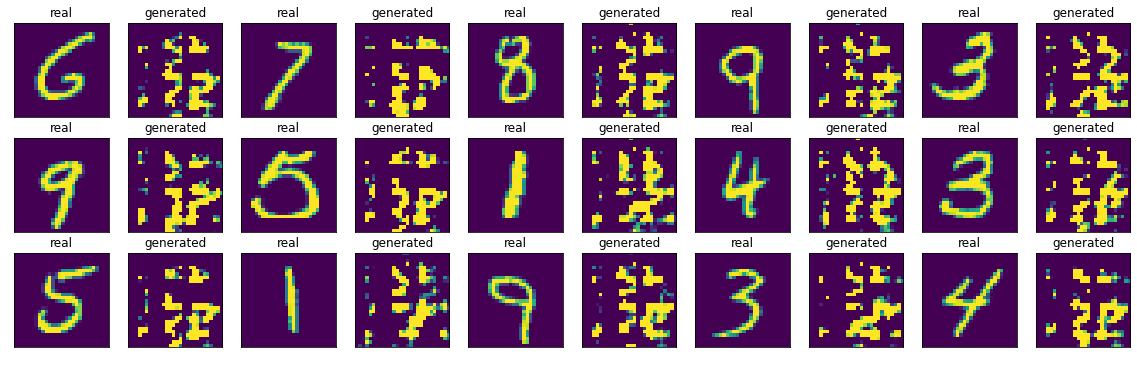

Validation loss: 9.36e-01
Iteration   40 - g_loss: 3.41e-06 - d_loss: 5.22e-07 - e_loss: 9.53e-01
Iteration   80 - g_loss: 3.09e-06 - d_loss: 5.64e-07 - e_loss: 9.53e-01
Iteration  120 - g_loss: 2.96e-06 - d_loss: 6.58e-07 - e_loss: 9.53e-01
Iteration  160 - g_loss: 2.84e-06 - d_loss: 6.62e-07 - e_loss: 9.52e-01
Iteration  200 - g_loss: 2.76e-06 - d_loss: 6.64e-07 - e_loss: 9.52e-01
Iteration  240 - g_loss: 2.76e-06 - d_loss: 7.38e-07 - e_loss: 9.52e-01
Iteration  280 - g_loss: 2.78e-06 - d_loss: 6.88e-07 - e_loss: 9.53e-01
Iteration  320 - g_loss: 2.83e-06 - d_loss: 7.55e-07 - e_loss: 9.53e-01
Iteration  360 - g_loss: 2.77e-06 - d_loss: 7.97e-07 - e_loss: 9.54e-01
Epoch 31 finished in 148.10s - g_loss: 2.75e-06 - d_loss: 7.76e-07 - e_loss: 9.54e-01


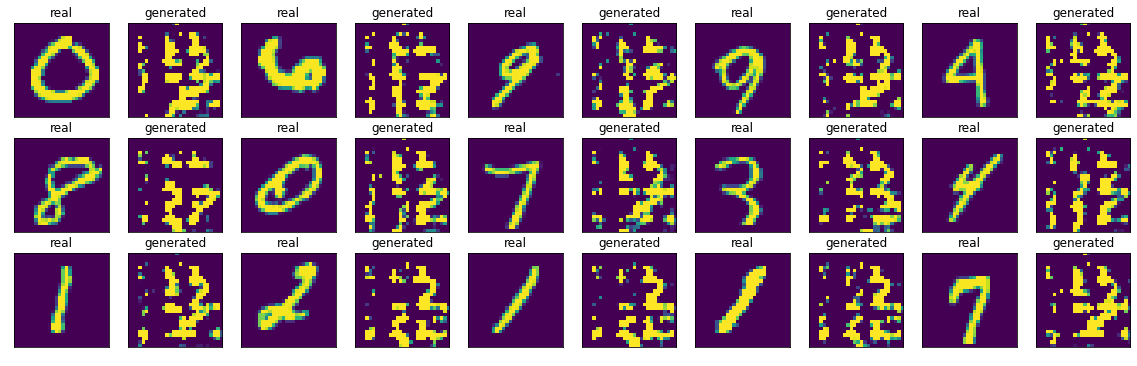

Validation loss: 9.32e-01
Iteration   40 - g_loss: 2.53e-06 - d_loss: 9.77e-07 - e_loss: 9.50e-01
Iteration   80 - g_loss: 2.55e-06 - d_loss: 7.63e-07 - e_loss: 9.52e-01
Iteration  120 - g_loss: 2.63e-06 - d_loss: 6.40e-07 - e_loss: 9.53e-01
Iteration  160 - g_loss: 2.52e-06 - d_loss: 5.82e-07 - e_loss: 9.52e-01
Iteration  200 - g_loss: 2.54e-06 - d_loss: 9.24e-07 - e_loss: 9.52e-01
Iteration  240 - g_loss: 2.57e-06 - d_loss: 9.67e-07 - e_loss: 9.52e-01
Iteration  280 - g_loss: 2.60e-06 - d_loss: 9.16e-07 - e_loss: 9.53e-01
Iteration  320 - g_loss: 2.59e-06 - d_loss: 9.31e-07 - e_loss: 9.52e-01
Iteration  360 - g_loss: 2.54e-06 - d_loss: 8.82e-07 - e_loss: 9.53e-01
Epoch 32 finished in 148.20s - g_loss: 2.55e-06 - d_loss: 8.45e-07 - e_loss: 9.52e-01


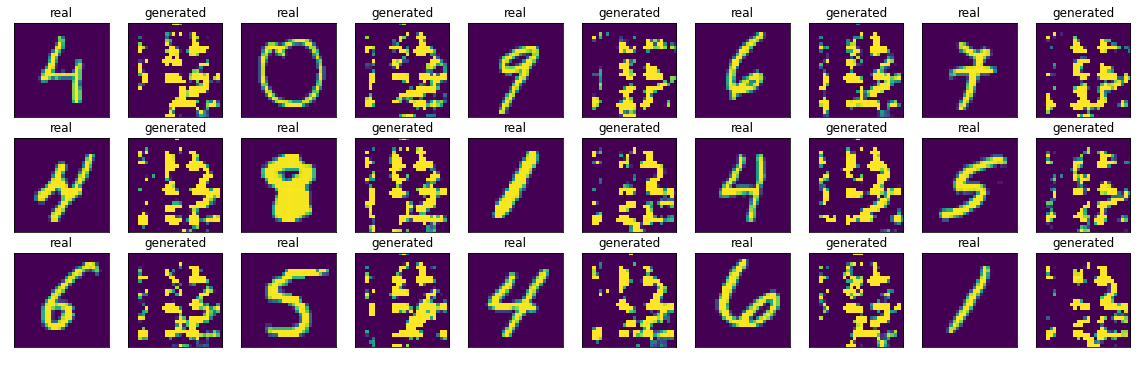

Validation loss: 9.36e-01
Iteration   40 - g_loss: 2.89e-06 - d_loss: 1.01e-06 - e_loss: 9.53e-01
Iteration   80 - g_loss: 2.35e-06 - d_loss: 8.25e-07 - e_loss: 9.51e-01
Iteration  120 - g_loss: 2.18e-06 - d_loss: 7.79e-07 - e_loss: 9.53e-01
Iteration  160 - g_loss: 2.34e-06 - d_loss: 7.07e-07 - e_loss: 9.52e-01
Iteration  200 - g_loss: 2.24e-06 - d_loss: 6.54e-07 - e_loss: 9.53e-01
Iteration  240 - g_loss: 2.30e-06 - d_loss: 6.27e-07 - e_loss: 9.53e-01
Iteration  280 - g_loss: 2.30e-06 - d_loss: 6.08e-07 - e_loss: 9.52e-01
Iteration  320 - g_loss: 2.24e-06 - d_loss: 5.88e-07 - e_loss: 9.53e-01
Iteration  360 - g_loss: 2.19e-06 - d_loss: 5.75e-07 - e_loss: 9.53e-01
Epoch 33 finished in 148.01s - g_loss: 2.16e-06 - d_loss: 5.60e-07 - e_loss: 9.53e-01


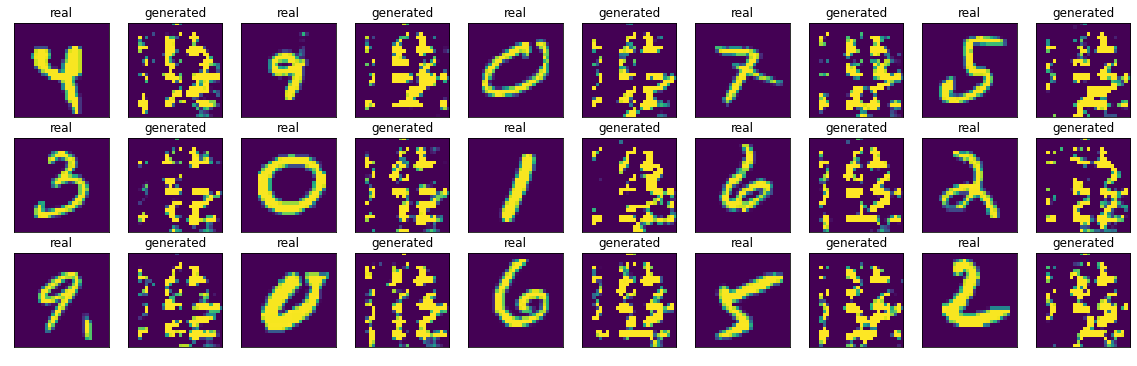

Validation loss: 9.34e-01
Iteration   40 - g_loss: 2.18e-06 - d_loss: 5.07e-07 - e_loss: 9.52e-01
Iteration   80 - g_loss: 2.01e-06 - d_loss: 8.02e-07 - e_loss: 9.51e-01
Iteration  120 - g_loss: 2.19e-06 - d_loss: 6.49e-07 - e_loss: 9.53e-01
Iteration  160 - g_loss: 2.10e-06 - d_loss: 5.73e-07 - e_loss: 9.53e-01
Iteration  200 - g_loss: 2.01e-06 - d_loss: 5.51e-07 - e_loss: 9.53e-01
Iteration  240 - g_loss: 1.94e-06 - d_loss: 5.04e-07 - e_loss: 9.52e-01
Iteration  280 - g_loss: 1.91e-06 - d_loss: 4.75e-07 - e_loss: 9.53e-01
Iteration  320 - g_loss: 1.90e-06 - d_loss: 4.61e-07 - e_loss: 9.52e-01
Iteration  360 - g_loss: 1.94e-06 - d_loss: 4.44e-07 - e_loss: 9.53e-01
Epoch 34 finished in 148.19s - g_loss: 1.92e-06 - d_loss: 4.64e-07 - e_loss: 9.53e-01


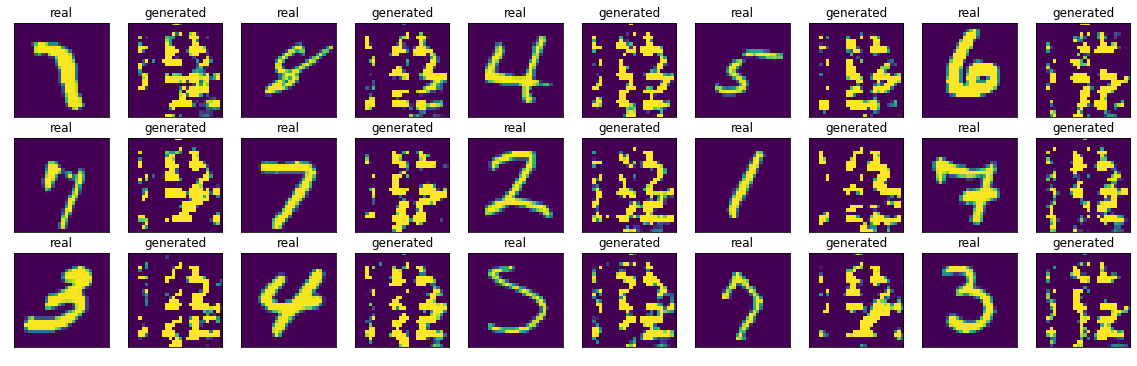

Validation loss: 9.34e-01
Iteration   40 - g_loss: 1.57e-06 - d_loss: 4.86e-07 - e_loss: 9.51e-01
Iteration   80 - g_loss: 1.63e-06 - d_loss: 4.38e-07 - e_loss: 9.52e-01
Iteration  120 - g_loss: 1.72e-06 - d_loss: 3.91e-07 - e_loss: 9.52e-01
Iteration  160 - g_loss: 1.76e-06 - d_loss: 3.95e-07 - e_loss: 9.52e-01
Iteration  200 - g_loss: 1.68e-06 - d_loss: 3.87e-07 - e_loss: 9.52e-01
Iteration  240 - g_loss: 1.69e-06 - d_loss: 3.77e-07 - e_loss: 9.51e-01
Iteration  280 - g_loss: 1.68e-06 - d_loss: 4.07e-07 - e_loss: 9.51e-01
Iteration  320 - g_loss: 1.72e-06 - d_loss: 4.10e-07 - e_loss: 9.51e-01
Iteration  360 - g_loss: 1.70e-06 - d_loss: 4.21e-07 - e_loss: 9.51e-01
Epoch 35 finished in 148.27s - g_loss: 1.67e-06 - d_loss: 4.04e-07 - e_loss: 9.51e-01


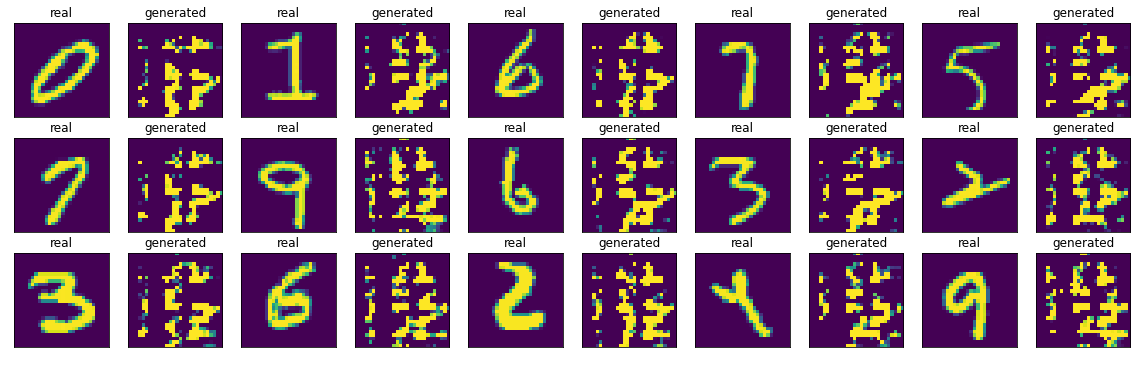

Validation loss: 9.40e-01
Iteration   40 - g_loss: 1.61e-06 - d_loss: 2.71e-07 - e_loss: 9.54e-01
Iteration   80 - g_loss: 1.46e-06 - d_loss: 2.97e-07 - e_loss: 9.52e-01
Iteration  120 - g_loss: 1.63e-06 - d_loss: 2.99e-07 - e_loss: 9.52e-01
Iteration  160 - g_loss: 1.56e-06 - d_loss: 3.07e-07 - e_loss: 9.52e-01
Iteration  200 - g_loss: 1.57e-06 - d_loss: 3.21e-07 - e_loss: 9.52e-01
Iteration  240 - g_loss: 1.57e-06 - d_loss: 3.33e-07 - e_loss: 9.53e-01
Iteration  280 - g_loss: 1.56e-06 - d_loss: 3.54e-07 - e_loss: 9.52e-01
Iteration  320 - g_loss: 1.55e-06 - d_loss: 3.39e-07 - e_loss: 9.52e-01
Iteration  360 - g_loss: 1.52e-06 - d_loss: 3.29e-07 - e_loss: 9.53e-01
Epoch 36 finished in 148.01s - g_loss: 1.52e-06 - d_loss: 3.28e-07 - e_loss: 9.53e-01


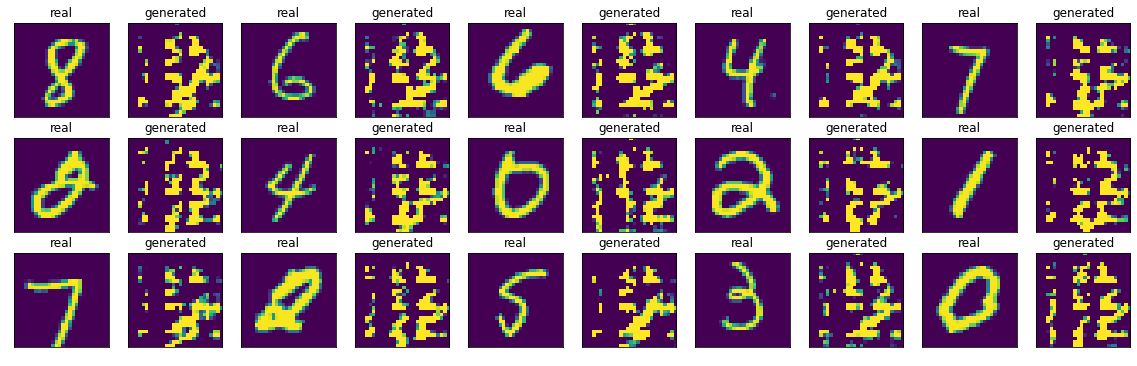

Validation loss: 9.32e-01
Iteration   40 - g_loss: 1.54e-06 - d_loss: 5.61e-07 - e_loss: 9.50e-01
Iteration   80 - g_loss: 1.50e-06 - d_loss: 3.93e-07 - e_loss: 9.50e-01
Iteration  120 - g_loss: 1.59e-06 - d_loss: 3.54e-07 - e_loss: 9.52e-01
Iteration  160 - g_loss: 1.49e-06 - d_loss: 3.33e-07 - e_loss: 9.51e-01
Iteration  200 - g_loss: 1.52e-06 - d_loss: 3.41e-07 - e_loss: 9.51e-01
Iteration  240 - g_loss: 1.51e-06 - d_loss: 3.41e-07 - e_loss: 9.51e-01
Iteration  280 - g_loss: 1.49e-06 - d_loss: 3.26e-07 - e_loss: 9.51e-01
Iteration  320 - g_loss: 1.47e-06 - d_loss: 3.20e-07 - e_loss: 9.51e-01


KeyboardInterrupt: ignored

In [107]:
epochs2 = 60

for e in range(epochs, epochs2):
    start_time = time()

    e_g_loss, e_d_loss, e_e_loss = train_cycleGAN(
        generator, discriminator, encoder,
        trainset,
        g_optimizer, d_optimizer, e_optimizer,
        batch_size, discriminator_step)
    
    end_time = time()

    torch.save(discriminator.state_dict(), f'drive/My Drive/cycle-gan-discriminator-model-e{e:02d}.pt')
    torch.save(generator.state_dict(), f'drive/My Drive/cycle-gan-generator-model-e{e:02d}.pt')
    torch.save(encoder.state_dict(), f'drive/My Drive/cycle-gan-encoder-model-e{e:02d}.pt')

    print(f'Epoch {e+1:2} finished in {end_time - start_time:.2f}s - g_loss: {e_g_loss:.2e} - d_loss: {e_d_loss:.2e} - e_loss: {e_e_loss:.2e}')

    g_loss.append(e_g_loss)
    d_loss.append(e_d_loss)
    e_loss.append(e_e_loss)

    eval_loss = evaluate_cycleGAN(generator, encoder, validationset, 5, 3, 256, 10)
    print(f'Validation loss: {eval_loss:.2e}')